In [1]:
#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

Range_MLD = {
    'lab' : {
        'vmin' : 20, 
        'vmax' : 2000},
    'gul' : {
        'vmin' : 20, 
        'vmax' : 1000},
    'noe' : {
        'vmin' : 10, 
        'vmax' : 1600},
}


#Colorbar parameters
color_bar = {
    'cmap' : 'YlGnBu',
    'orientation' : 'vertical',
    'title_cbr' : 'depth [m]'
}



reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

In [3]:
def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


In [4]:
dir_1 = '/home/lgarcia/Documents/data_ARMOR/'
fl_n1 = 'ARMOR_*.nc'

c_armor = xr.open_mfdataset(dir_1 + fl_n1)
mld_a = c_armor.mlotst

## Just a test to plot histograms

In [ ]:
## some other packages
from scipy import stats
from matplotlib import ticker

In [ ]:
mx = np.nanmax(mld_a[:])
mn = np.nanmin(mld_a[:])

print(mx, mn)
d_frame = mld_a[250].to_dataframe()
d_nonan = d_frame.dropna(how='any')

#%matplotlib notebook

plt.yscale("log")

values = d_nonan.mlotst
n, bins, patches = plt.hist(values, 20, range=(mn, mx), facecolor='g', alpha=0.75)

#plt.grid()
#plt.show()

#print(patches)
#print(bins)


## Making the histogram for each time stamp

In [5]:
## Function to crop the dataset

def Crops(coord, d_set):
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))


In [52]:
def Hist_params(data_set, n_bins):
    """
        Hist_param is a function that generates an histogram for each time step
        of a DataArray.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset we are working on
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    heigth = np.empty(n_bins)
    
    for i in range(len(data_set.week)):
        d_frame = data_set[i].dropna(dim='longitude', how='any')
        d_frame = data_set[i].dropna(dim='latitude', how='any')

        #mean = d_nonan.mlotst.mean()
        #sd = d_nonan.std()
        #a = np.append(a, mean)
        #s = np.append(s, sd)

        values = d_frame
        hist, bins = np.histogram(values, bins=n_bins, range=(mn, mx), normed=False)

        heigth = np.vstack((heigth, hist))
        
    h = np.delete(heigth, 0, 0)
    
    return(h)
    

def PDF_time(data_set, mini, maxi, n_bins, *limits):
    """
        PDF_time is a function that generates a 2D plot from histograms
        and time steps. This is the plot will have as 'x' axis values of MLD
        classes in meters, and the 'y' axis will have time dimensions. The 
        colors indicate the number of grid points in each MLD class.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset we are working on
            
        mini : float
            minimum value to create the 'y' axis
            
        maxi : float
            maximum value to create the 'y' axis
            
        n_bins : integer
            Is the number of bins we assign for the histogram
        
        Output:
        -------
        h : Numpy Arrray
            Array with the parameters of the histogram for each time stamp. 
            It has dimension time_stamps x n_bins 
    """
    x = data_set.week
    y = np.arange(mini, maxi, abs((mini-maxi)/n_bins))
    X, Y = np.meshgrid(x, y)

    hist = Hist_params(data_set, n_bins)
    
    #Minimum and maximum values for the color bar
    vmin = hist.min()
    vmax = hist.max()

    fig, ax = plt.subplots()

    #ax.set_yscale("log", nonposy='clip')
    cs = ax.contourf(X, Y, hist.T, np.linspace(limits[0], limits[1], 25), cmap='viridis', extend='max')

    ax.set_xlabel('time [weeks]')
    ax.set_ylabel('MLD [m]')
    #ax.set_title('Gulf Stream MLD distribution')

    cb = fig.colorbar(cs, ax=ax, orientation='vertical')
    cb.set_label('# of grid points')
    #ax.set_clim(10., 4000.)
    
    plt.show()
    ##Deberia regresar o no la figura?
    
    
    
def Save_fig(name):
    fig.savefig(name, bbox_inches='tight')
    

def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

### Gulf stream

In [41]:
from matplotlib.colors import LogNorm
coord = 'gul'
gulf_data = Crops(coord, c_armor)
gulf_data = Masking(gulf_data, gulf_data.to[0,25])

gulf_data = gulf_data.groupby('time.week').mean(dim='time')

In [42]:
gulf_data.mlotst

<xarray.DataArray 'mlotst' (week: 53, latitude: 60, longitude: 120)>
dask.array<shape=(53, 60, 120), dtype=float32, chunksize=(1, 60, 120)>
Coordinates:
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
  * longitude  (longitude) float32 -74.875 -74.625 -74.375 ... -45.375 -45.125
    mask       (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


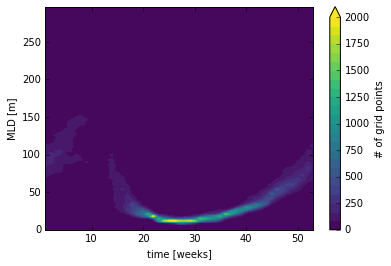

In [56]:
n_bins = 100
mn = 0.
mx = 300.

clims_g = (0., 2000.)
values = gulf_data.mlotst.where(gulf_data.mask==1)

PDF_time(values, mn, mx, n_bins, *clims_g)

### Labrador and Irminger seas

In [38]:
coord = 'lab'
lab_data = Crops(coord, c_armor)
lab_data = Masking(lab_data, lab_data.to[0,25])
lab_data = lab_data.groupby('time.week').mean(dim='time')

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


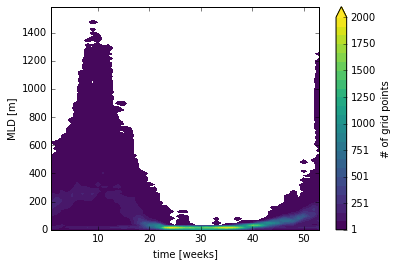

In [58]:
n_bins = 100

mn = 0.
mx = 1600.

clims_l = (1., 2000.)
values_l = lab_data.mlotst

PDF_time(values_l, mn, mx, n_bins, *clims_l)

### North East

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


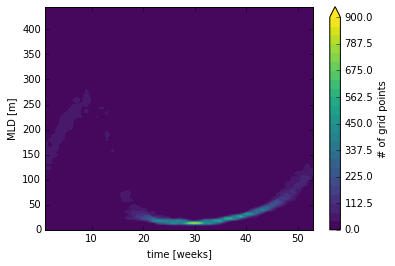

In [60]:
coord = 'noe'
noe_data = Crops(coord, c_armor)
noe_data = Masking(noe_data, noe_data.to[0,25])
noe_data = noe_data.groupby('time.week').mean(dim='time')

n_bins = 100

mn = 0.
mx = 450.

clims_n = (0., 900.)
values_n = noe_data.mlotst.where(noe_data.mask==1)

PDF_time(values_n, mn, mx, n_bins, *clims_n)